# Modeling the roles of copper and zinc in neurofibromatosis cell signaling

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from pysb import Observable
from pysb.simulator import ScipyOdeSimulator
from indra.sources import trips
from indra.assemblers.pysb import PysbAssembler
from indra.explanation.model_checker.pysb import PysbModelChecker

import networkx as nx
import pygraphviz as pgv
from IPython.display import Image
from pysb.tools import render_reactions

## Model assumptions

First off, the basics of RAS signaling upstream of MEK. We model RAS as constitutively active to represent the effects of NF1 loss of function.

In [2]:
model_text = """
    RAS activates RAF.
    Active RAF phosphorylates MEK.
    RAS activates PI3K.
    Active PI3K activates AKT.
    Active AKT activates MTOR.
"""

"Recombinant Mek1 binds two Cu atoms with high affinity and Cu enhances Mek1 phosphorylation of Erk in a dose-dependent fashion." (Turski et al. 2012).

In [3]:
model_text += """
    Phosphorylated MEK binds copper atom.
    MEK bound to copper atom phosphorylates ERK.
    """

"Copper uptake via CTR1 allosterically activates MEK1 to potentiate oncogenic signaling via the MAP kinase pathway."

In [4]:
model_text += """
    CTR1 increases copper atom.
    Copper atom not bound to MEK is degraded.
"""

## Step 1: Model text to INDRA Statements

Use the TRIPS/DRUM NLP system to convert the sentences above into INDRA statements. This can take 15-20 seconds.

In [5]:
%time tp = trips.process_text(model_text, service_endpoint='drum-dev')

CPU times: user 11 s, sys: 353 ms, total: 11.4 s
Wall time: 17.3 s


In [6]:
statements = tp.statements
statements

[Complex(MEK(mods: (phosphorylation)), COPPER-ATOM()),
 Phosphorylation(RAF(activity), MEK()),
 Phosphorylation(MEK(bound: [COPPER-ATOM, True]), ERK()),
 Activation(RAS(), RAF()),
 Activation(RAS(), PI3K()),
 Activation(PI3K(activity), AKT()),
 Activation(AKT(activity), MTOR()),
 DecreaseAmount(None, COPPER-ATOM(bound: [MEK, False])),
 IncreaseAmount(SLC31A1(), COPPER-ATOM())]

## Step 2: INDRA Statements to PySB model

In [7]:
pysb_asmb = PysbAssembler(statements)
model = pysb_asmb.make_model()

INFO: [2021-05-02 16:54:05] indra.assemblers.pysb.assembler - Using default assembly policy.
INFO: [2021-05-02 16:54:05] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.12/bio_ontology.pkl


Let's look at the model rules:

In [8]:
model.rules

ComponentSet([
 Rule('MEK_phospho_COPPER_ATOM_bind', MEK(phospho=('p', WILD), copper_atom=None) + COPPER_ATOM(map2k=None) >> MEK(phospho=('p', WILD), copper_atom=1) % COPPER_ATOM(map2k=1), kf_mc_bind_1),
 Rule('MEK_COPPER_ATOM_dissociate', MEK(copper_atom=1) % COPPER_ATOM(map2k=1) >> MEK(copper_atom=None) + COPPER_ATOM(map2k=None), kr_mc_bind_1),
 Rule('RAF_act_phosphorylation_MEK_phospho', RAF(activity='active') + MEK(phospho='u') >> RAF(activity='active') + MEK(phospho='p'), kf_rm_phosphorylation_1),
 Rule('MEK_COPPER_ATOM_phosphorylation_ERK_phospho', MEK(copper_atom=ANY) + ERK(phospho='u') >> MEK(copper_atom=ANY) + ERK(phospho='p'), kf_me_phosphorylation_1),
 Rule('RAS_activates_RAF_activity', RAS() + RAF(activity='inactive') >> RAS() + RAF(activity='active'), kf_rr_act_1),
 Rule('RAS_activates_PI3K_activity', RAS() + PI3K(activity='inactive') >> RAS() + PI3K(activity='active'), kf_rp_act_1),
 Rule('PI3K_act_activates_AKT_activity', PI3K(activity='active') + AKT(activity='inactive'

We use the INDRA Model Checker tools to generate the Kappa influence map to look at the causal influences between rules; the Model Checker also adds the observables that we'll want to plot in simulation.

In [9]:
pmc = PysbModelChecker(model, statements, model_stmts=statements)
im = pmc.get_im(force_update=True)
pmc.prune_influence_map()
model = pmc.model

INFO: [2021-05-02 16:54:15] indra.explanation.model_checker.pysb - Generating influence map
INFO: [2021-05-02 16:54:16] indra.explanation.model_checker.pysb - Removing self loops
INFO: [2021-05-02 16:54:16] indra.explanation.model_checker.pysb - Get successors of each node
INFO: [2021-05-02 16:54:16] indra.explanation.model_checker.pysb - Compare combinations of successors
INFO: [2021-05-02 16:54:16] indra.explanation.model_checker.pysb - Removing 2 edges from influence map


## Visualizing the structure of the model

Convert the networkx representation of the influence map into a PyGraphViz
graph so that we can visualize it:

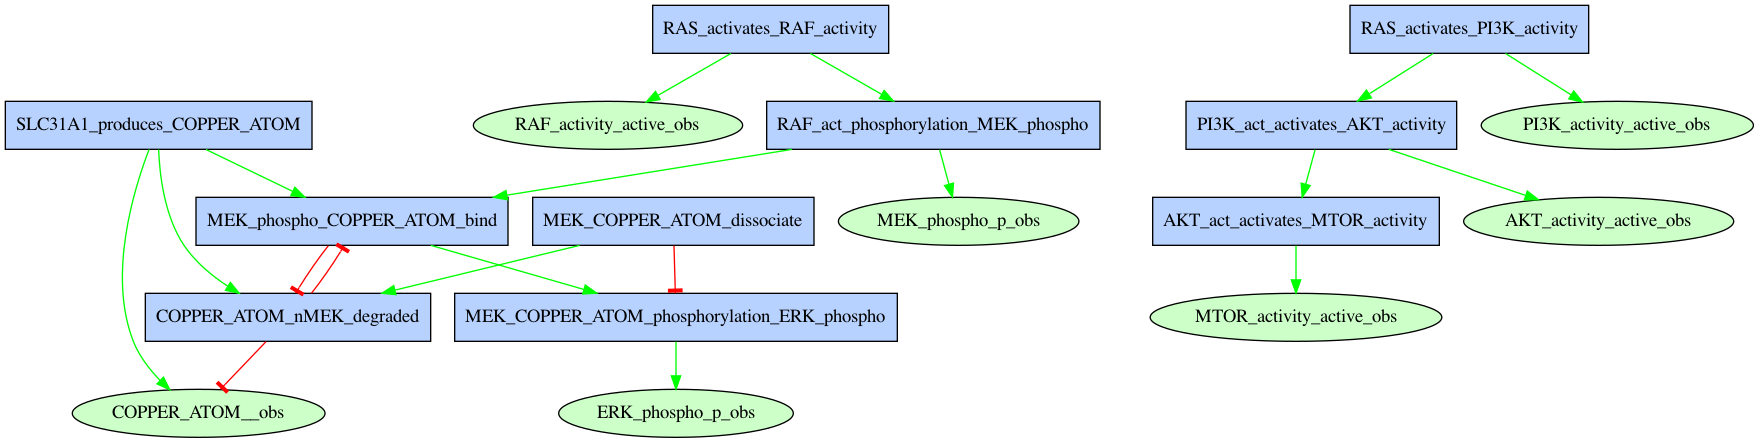

In [11]:
im_pgv = nx.nx_agraph.to_agraph(im)
Image(data=im_pgv.draw(format='png', prog='dot'))

We can also look at the chemical reaction network which shows the detailed conversions of each chemical species via distinct reactions. The blue nodes are chemical species that are specified as initial conditions:

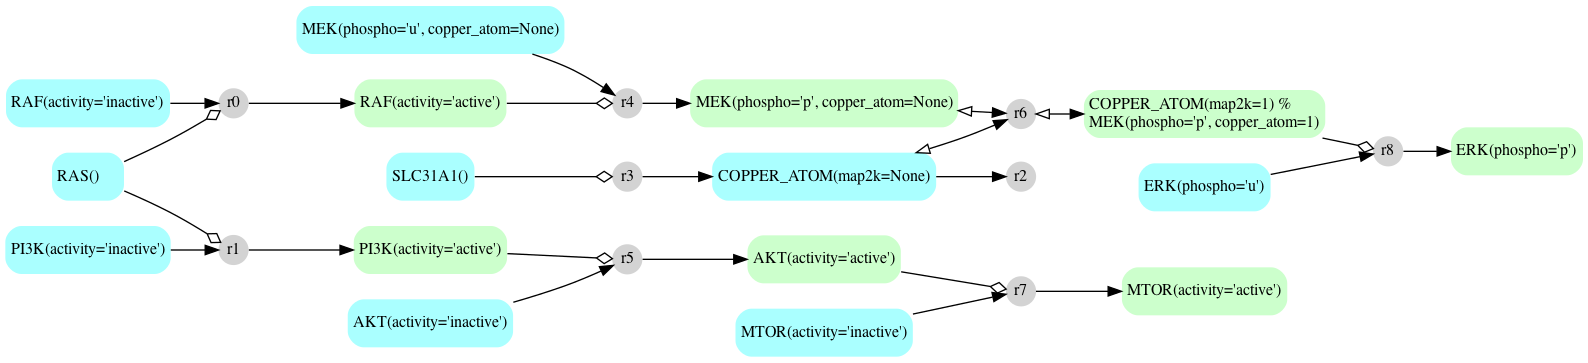

In [12]:
rxns = pgv.AGraph(render_reactions.run(model))
Image(data=rxns.draw(format='png', prog='dot'))

## Simulate the model

Before simulating, we add an observable for MEK bound to copper in case we want to look at this at some point:

In [13]:
model.enable_synth_deg()
m = model.monomers
mek_cu = m['MEK'](copper_atom=1) % m['COPPER_ATOM'](map2k=1)
mek_cu_obs = Observable('MEK_Cu_obs', mek_cu)
model.add_component(mek_cu_obs)

Take a look at the model parameters:

In [14]:
model.parameters

ComponentSet([
 Parameter('kf_mc_bind_1', 1e-06),
 Parameter('kr_mc_bind_1', 0.1),
 Parameter('kf_rm_phosphorylation_1', 1e-06),
 Parameter('kf_me_phosphorylation_1', 1e-06),
 Parameter('kf_rr_act_1', 1e-06),
 Parameter('kf_rp_act_1', 1e-06),
 Parameter('kf_pa_act_1', 1e-06),
 Parameter('kf_am_act_1', 1e-06),
 Parameter('kf_c_deg_1', 2e-05),
 Parameter('kf_sc_synth_1', 0.0002),
 Parameter('MEK_0', 10000.0),
 Parameter('COPPER_ATOM_0', 10000.0),
 Parameter('RAF_0', 10000.0),
 Parameter('ERK_0', 10000.0),
 Parameter('RAS_0', 10000.0),
 Parameter('PI3K_0', 10000.0),
 Parameter('AKT_0', 10000.0),
 Parameter('MTOR_0', 10000.0),
 Parameter('SLC31A1_0', 10000.0),
 ])

For simplicity, for now we'll ignore the role of copper import/export by setting the rate for the copper transport and decay reactions to 0 so that copper has a fixed concentration:

In [15]:
# Copper transport reaction:
model.parameters['kf_sc_synth_1'].value = 0
# Copper decay reaction:
model.parameters['kf_c_deg_1'].value = 0

Define the time duration of the simulation:

In [16]:
t = np.linspace(0, 4000, 101)

Set the baseline initial condition for copper and simulate as a set of ODEs:

In [17]:
# Initial condition for copper (arbitrary)
model.parameters['COPPER_ATOM_0'].value = 10000
# Simulate
copper_sim = ScipyOdeSimulator(model, tspan=t, cleanup=True,
                               compiler='python').run()

Now run a simulation without copper by setting the initial condition parameter for copper to 0:

In [18]:
# Initial condition parameter for copper
model.parameters['COPPER_ATOM_0'].value = 0
# Simulate again
no_copper_sim = ScipyOdeSimulator(model, tspan=t, cleanup=True,
                                  compiler='python').run()

Plot the amount of phospho-ERK (a key readout of pro-growth signaling) with and without copper:

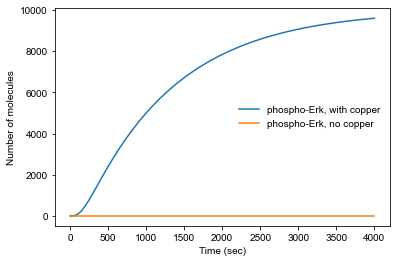

In [19]:
plt.figure()
# Plot phospho-ERK WITH copper
plt.plot(t, copper_sim.observables['ERK_phospho_p_obs'],
         label='phospho-Erk, with copper')
# Plot phospho-ERK WITHOUT copper
plt.plot(t, no_copper_sim.observables['ERK_phospho_p_obs'],
         label='phospho-Erk, no copper')
plt.legend(loc='right', frameon=False)
plt.xlabel('Time (sec)')
plt.ylabel('Number of molecules')
plt.show()